# Eddy current losses model


To model eddy current losses custom resistor-inductor loops can be implemented. The inductor in each loop is coupled to every inductor in the model, as shown in figure below. The figure also shows the parallel resistance.
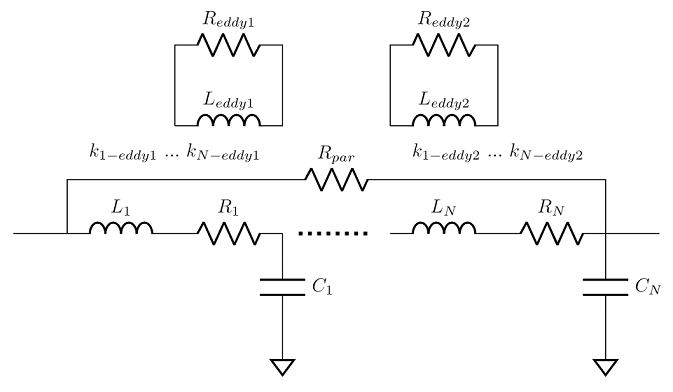


# Import Java gateway and STEAM API (SING, UTILS), and find eos path

In [1]:
import sys
!{sys.executable} -m pip install --user --upgrade steam-nb-api

from steam_nb_api.utils.FrequencyModelling import FrequencyModelling
import os


import xlrd
import traceback # used for the exception

%load_ext autoreload
%autoreload 2

Requirement already up-to-date: steam-nb-api in /eos/home-e/emm/.local/lib/python3.8/site-packages (0.3.22)


# Inputs (Only change this if the file location of the input file changes)

In [2]:
# Assumption: this code is always run inside SWAN_projects for now, meaning that the first part of the location, in particulairly the user, can be found by searching for 'SWAN_projects' in os.getcwd()

inputpath = 'SWAN_projects/steam-notebooks/steam-frequency-input/magnets/LEDET_Magnets_inputs.xls'  # The file location of the input specifications excel file

########################## Everthing below this line shouldn't be changed ##########################
eospath = os.getcwd()
eossplit = eospath.split(os.path.sep)
SWAN_index = eossplit.index('SWAN_projects')  # If this line throws an error it is most likely because the current working directory doesn't include 'SWAN_projects'
eospath = ''
for j in range(SWAN_index):
    eospath = eospath + eossplit[j] + '/'

inputname = eospath + inputpath

xl_workbook = xlrd.open_workbook(inputname)
a = xl_workbook.sheet_by_index(0)

magnets_name_all = []
for i in range(2, a.nrows):
    magnets_name_all.append(a.cell(i, 0).value)

# print with index
print('List of all magnets: Index')
for i in range(len(magnets_name_all)):
    if len(magnets_name_all[i]) > 7:
        tabs = '\t   :'
    else:
        tabs = '\t\t   :'
    if i > 99:
        spaces = ' '
    elif i > 9:
        spaces = '  '
    else:
        spaces = '   '
    s = str(magnets_name_all[i]) + tabs + spaces + str(i)
    print(s)



List of all magnets: Index
D1		   :   0
D2		   :   1
ERMC_V1		   :   2
MB		   :   3
MBRB		   :   4
MBRC		   :   5
MBRS		   :   6
MBX		   :   7
MCBXH		   :   8
MCBYH_1AP	   :   9
MCBYV_1AP	   :  10
MCDO		   :  11
MCS		   :  12
MO_1AP		   :  13
MQM		   :  14
MQMC		   :  15
MQML		   :  16
MQS_1AP		   :  17
MQTLH_1AP	   :  18
MQTLI_1AP	   :  19
MQT_1AP		   :  20
MQXA		   :  21
MQXB		   :  22
MQXF_V2		   :  23
MQY_2in1	   :  24
MQ_1AP		   :  25
MSS_1AP		   :  26
MS_1AP		   :  27
d11T_2in1	   :  28
HEPDipo_4COILS	   :  29
MCBXV		   :  30
MCD		   :  31
MCO		   :  32
MQY_8Coils	   :  33
RMM_V1		   :  34
d11T_1in1	   :  35
MQSX		   :  36


# Magnet selection (CHANGE THIS CELL)

In [3]:
# Magnets_name needs to be changed to contain a list of the magnets chosen to run.

# Examples of possible magnet name lists:
magnets_name = [magnets_name_all[3]] #Only one magnet (needs to be a list, hence the brackets are added)
#magnets_name = magnets_name_all[0:2] # Subset of magnets
#magnets_name = [magnets_name_all[0], magnets_name_all[1]]+ magnets_name_all[3:8]+[magnets_name_all[21]] # Alternative subset of magnets
#magnets_name = magnets_name_all[19:21]+[magnets_name_all[27]] # Alternative subset of magnets
#magnets_name = magnets_name_all[19:21] # Alternative subset of magnets
# magnets_name = magnets_name_all # All magnets

# If flag_print = 1 then details from the model generation are printed
flag_print = 1

print('List of magnets chosen to run:')
print(magnets_name)

List of magnets chosen to run:
['MB']


# Run model

In [4]:
errors = 0
for i in range(len(magnets_name)):
    nameMagnet = magnets_name[i]
    swanpath='/SWAN_projects/steam-notebooks/steam-ledet-input/'+nameMagnet+'/' # This string should always start with '/SWAN_projects/'! everything else after that needs to be changed to the needed path 
    s = 'Currently running magnet ' + str(i+1) + ' of ' + str(len(magnets_name)) +': ' + nameMagnet
    print(s)
    
    try:
        model = FrequencyModelling(magnets_name[i],swanpath,inputpath,flag_print)
        L_turns, L_groups, k_turns, k_groups = model.SelfMutualInductance()
        R_turns, R_groups = model.Resistance()
        C_turns, ind_turns, C_groups, ind_groups = model.CapacitanceToGround()
        Capacity_T2T_turns, Contact_From_turns, Contact_To_turns, Capacity_T2T_groups, Contact_From_groups, Contact_To_groups = model.CapacitanceT2T()
        # INFO: the netlist objects can get corrupted from being passed between functions
        flag_netlist_error = 0 # Since each netlist is tried by themselves, they can create two errors per magnet, this flag makes sure only one error is counted per magnet.
        try:
            netlist_turns , netlistAsListString_turns = model.netlist(L_turns,R_turns,C_turns,ind_turns,k_turns,Capacity_T2T_turns,Contact_From_turns,Contact_To_turns)
        except:
            print('')
            s = 'Problem with the turn netlist for magnet: ' + magnets_name[i]
            print(s)
            print(traceback.format_exc())
            flag_netlist_error = 1
            errors = errors + 1
        try:  
            netlist_groups , netlistAsListString_groups = model.netlist(L_groups,R_groups,C_groups,ind_groups,k_groups,Capacity_T2T_groups,Contact_From_groups,Contact_To_groups)
        except:
            print('')
            s = 'Problem with the group netlist for magnet: ' + magnets_name[i]
            print(s)
            print(traceback.format_exc())
            if ~flag_netlist_error:
                flag_netlist_error = 1
                errors = errors + 1
        try:  
            netlist_magnet , netlistAsListString_magnet = model.netlistMagnet()
        except:
            print('')
            s = 'Problem with the magnet netlist for magnet: ' + magnets_name[i]
            print(s)
            print(traceback.format_exc())
            if ~flag_netlist_error:
                errors = errors + 1
    except Exception as inst:
        print('')
        s = 'Problem with the magnet: ' + magnets_name[i]
        print(s)
        print(traceback.format_exc())
        errors = errors + 1
    print('')
    print('###################################################################################')
    print('')


e = 'Amount of errors: ' + str(errors)
s = 'Amount of succesful runs: ' + str(len(magnets_name)-errors)
print(e)
print(s)

Currently running magnet 1 of 1: MB

1 coil sections defined.
48 groups defined.
24 turn-groups defined.

Self-mutual inductance between strands - Calculation started
Calculation does not include correction for strand diameter.
Status: [------------------->] 100%
Self-mutual inductance between strands - Calculation finished
Self-mutual inductance between half-turns - Calculation started
Self-mutual inductance between half-turns - Calculation finished
Self-mutual inductance between turns - Calculation started
Self-mutual inductance between turns - Calculation finished

Total magnet self-inductance per unit length: 0.006064692646611455 H/m

Number of deviations: 0 out of 25600

Total inductance:
0.09791783119060946 H

max |k_turns| (should be lower than 1):
0.8762156428432792

max |k_groups| (should be lower than 1):
0.707403612242247
 
Time stamp: 2021-05-03 01:33:27.339520
Turn-based netlist file generated.
 
Time stamp: 2021-05-03 01:33:30.771986
Group-based netlist file generated.
 
